In [124]:
import os
import tensorflow as tf
import numpy as np
import re
from collections import Counter
import keras
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import layers
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPooling2D, Dropout,MaxPool2D, Flatten, Dense
from keras import Input, Model
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, accuracy_score,f1_score,precision_score, recall_score,roc_curve, roc_auc_score


# Breast Tumor Segmentation and Prediction

## Introduction

- This project has 2 main goals: Segment breast tumors and predict if the tumor is benign or malignant from Ultrasound images.
- The first task is a image segmantetion task, in which my model will show where the tumors are in the ultrasound scans.
- The second task is a binary classification task, in which my model will predict if the tumors are beign or cancerous. Benign tumors/masses are collections of abnormally grown cells. They usually have a define border and don't spread to other organs or cause any health problems. Benign masses in the breasts are common.
- This project is important because breast cancer is one of the leading causes of cancer death in the world. Early detection of breast cancer can significantly increase treatment efficacy and patient survival. One of the most common non invasive and inexpensive breast cancer detection methods is ultrasound. I hope that my deep learning models can be used as an aid for physicians in diagnosing breast cancer.
- The data set I use for this project is the Kaggle dataset: Breast Ultrasound Images Dataset(BUSI). This data set include ultrasound scans of breast masses and their segmentation made by human experts. The scans are also identified as benign or malignant.


https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset/data

## Exploratory Data Analysis (EDA)

### Import and preprocess images and masks
This data set includes images around 500x500 of ultrasound scans and their tumor segmentation (masks). The images are from 2 separate folders (benign and malignant) for the 2 classes.

I will write a function to import and preprocess the images. These are the following steps:
- First, get file names of files in the folder (benign or malignant).
- Get the file names for the masks.
- I notice that some of the scans have multiple masks of different tumors, so I identify the images with multiple masks. Then, I combine the masks of those images. After this, each scan only has 1 mask.
- Read images and masks. Convert them to grayscale (because ultrasound images are black and white).
- Normalize pixel values from (0,255) to (0,1) by dividing by 255.
- Resize all scans and masks to 256x256

After this function, the output images and masks will be arrays of dimension 256x256.



In [38]:
# Import images
def import_process_images_masks(folder_path):
    #Get file names
    filenames = sorted(os.listdir(folder_path))
    #Get masks id
    mask_file= [f for f in filenames if "mask" in f]
    mask_id = np.squeeze([re.findall(r'\(.*?\)', f) for f in mask_file])
    #Identify images with multiple masks
    mask_count = Counter(mask_id)
    dup_mask_id = list([item for item in mask_count if mask_count[item]>1])
    mask_id_filtered= np.unique(mask_id)
    
    masks=[]
    for ID in mask_id_filtered:
        #Combine masks if images have multiple masks
        if ID in dup_mask_id:
            dup_masks = np.array([cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE) for f in filenames if ID+"_mask" in f])
            combined_masks=sum(dup_masks)
            masks.append(combined_masks)
        else:
            for f in filenames:
                if ID+"_mask" in f:
                    masks.append(cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE))
    #Read images
    images = [cv2.imread(os.path.join(folder_path, f)) for f in filenames if "_mask" not in f]
    
    #Convert images to gray scale
    images=[cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    
    #Normalize pixel values to (0,1)
    masks=[mask/255.0 for mask in masks]
    images=[image/255.0 for image in images]

    #resize images and masks
    images = [cv2.resize(image, (256,256)) for image in images]
    masks = [cv2.resize(mask, (256,256), interpolation=cv2.INTER_NEAREST) for mask in masks]
    
    return np.array(images), np.array(masks)


Let's import and preprocess all the images and masks. 

The following code plot some example images and masks of benign and malignant classes.

<function matplotlib.pyplot.show(close=None, block=None)>

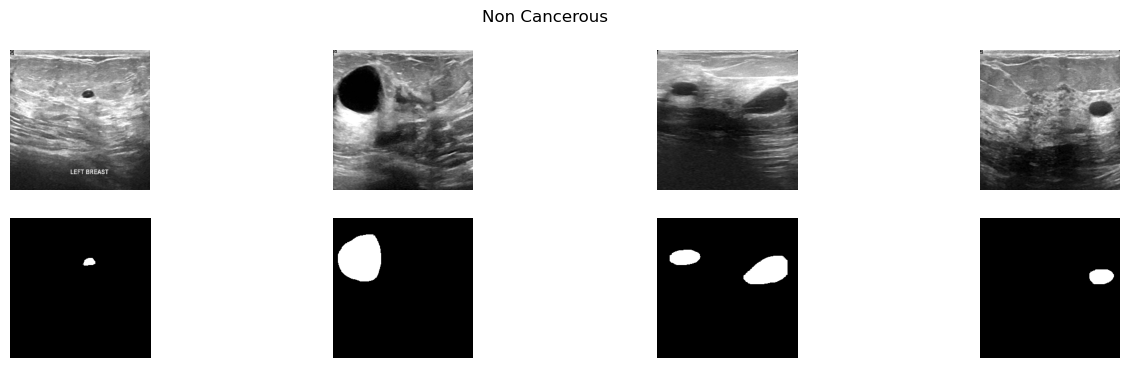

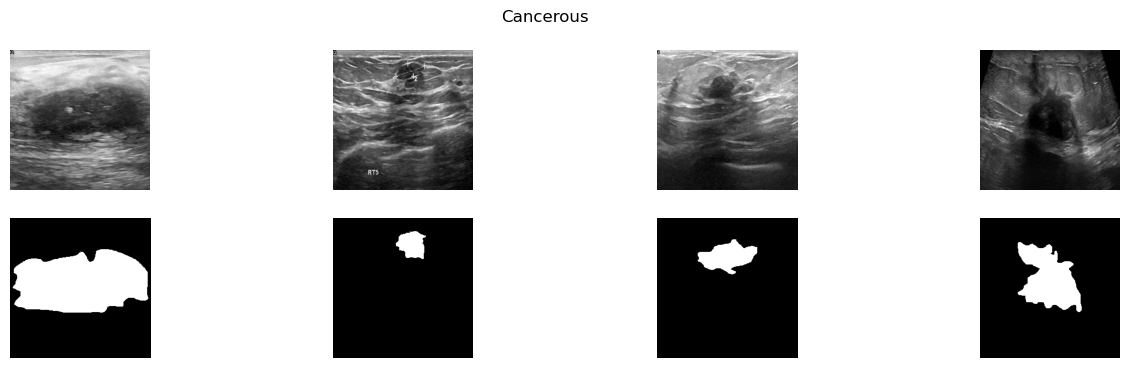

In [39]:
# Import and preprocess images
benign_images,benign_masks=import_process_images_masks("benign")
mal_images,mal_masks=import_process_images_masks("malignant")

#Show example images
#Benign
plt.figure(figsize=(16, 4))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(benign_images[i], cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 4, i+5)
    plt.imshow(benign_masks[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Non Cancerous")
plt.show

#Malignant
plt.figure(figsize=(16, 4))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(mal_images[i], cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 4, i+5)
    plt.imshow(mal_masks[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Cancerous")
plt.show


The data is clean now. At first glance, I notice that the malignant tumors usually have an irregular boundaries while the benign tumors have rounder boundaries.

The masks are images of 0 and 1 (0: non tumor, 1: tumor).

### Create classes label

Let's create labels for each image and mask. The labels can be 0 or 1 (0: benign, 1: malignant).

After that, I join all the images, masks, and labels together. I split them into training and validation sets with the test size of 0.2.

I also used straified splitting, which ensures the training and testing sets have the same class ratio with the original data set. This would prevent class imbalance from affecting my model preformance.

In [40]:
#Create labels
benign_labels = np.zeros(len(benign_images))
mal_labels = np.ones(len(mal_images))

#Concatenate benign and malignant images
Scan_images=np.concatenate((benign_images, mal_images))
Scan_masks=np.concatenate((benign_masks, mal_masks))
Scan_labels=np.concatenate((benign_labels, mal_labels))

#Split train and test
image_train, image_test, mask_train, mask_test, label_train, label_test =train_test_split(Scan_images, Scan_masks, Scan_labels, stratify= Scan_labels, test_size=0.2,random_state=21)

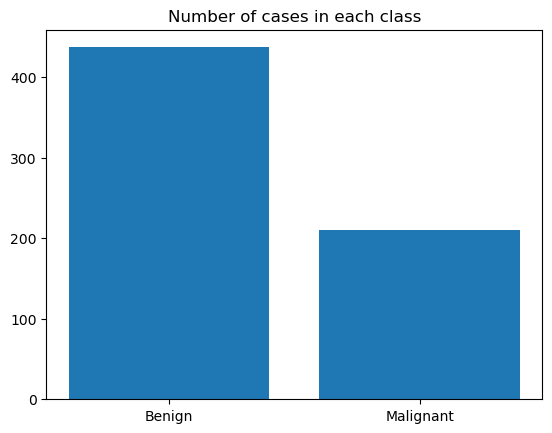

In [185]:
# Number of images in each class
Pos_num=sum(Scan_labels)
Neg_num=len(Scan_labels)-Pos_num

x = np.array(["Benign", "Malignant"])
y = np.array([Neg_num, Pos_num])

plt.bar(x,y)
plt.title("Number of cases in each class")
plt.show()

We see that the number of Malignant images are lower than benign cases.

### Data augmentation

My training set is not too large (517 images in total). This could prevent my model from learning all the details and patterns from the scans. Deep learning model benefits greatly from a large training set. Therefore, to increase my training set, I will augment my data.

Data augmentation is a common practice to increase training set size by randomly altering the data. In this case, I will randomly flip the images horizontally and rotate images by 0.2 rad (36 degrees).

I will perform data augmentation 3 times and add to my original training set. This would increase my training set by 4 times (517x4=2068).


In [41]:
#Data augmentation
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.2)])

#Merge images and masks together
combined_img=np.array([cv2.merge((image_train[i], mask_train[i])) for i in range(mask_train.shape[0])])
augmented_img=combined_img.copy()

#Augment images and masks 3 times
for i in range(3):
    augmented = np.array(data_augmentation(combined_img))
    augmented_img=np.concatenate((augmented_img,augmented))


2024-09-20 18:11:22.937274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-09-20 18:11:24.750666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-09-20 18:11:26.397519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


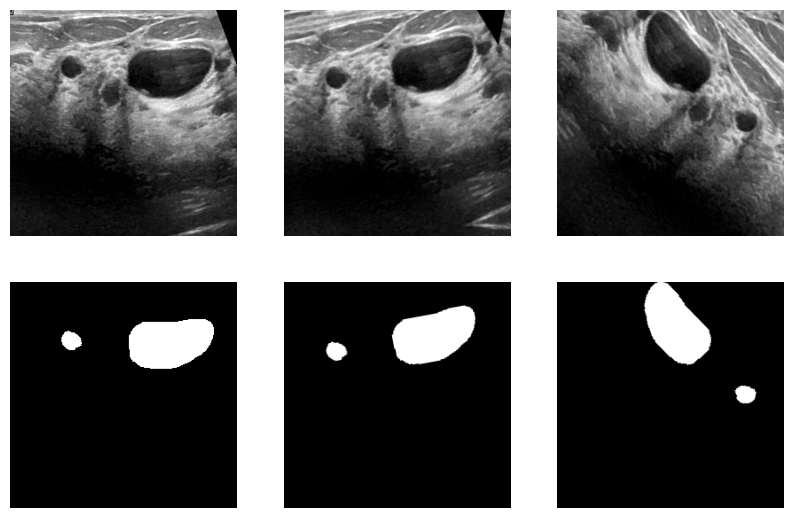

In [187]:
# Extract augmented images and masks
image_train_aug=augmented_img[:,:,:,0]
mask_train_aug=augmented_img[:,:,:,1]

#Add augmented labels
label_train_aug=label_train.copy()
for i in range(3):
    label_train_aug=np.concatenate((label_train_aug,label_train))

# Show an example of augmented data
plt.figure(figsize=(10, 10))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_train_aug[i*517],cmap='gray')
    plt.axis("off")
    plt.subplot(3, 3, i + 4)
    plt.imshow(mask_train_aug[i*517],cmap='gray')
    plt.axis("off")

The images and masks are randomly flipped and rotated. This has increased my training set by 4 times. Data augmentation will improve my model preformance.

## Segmentation Model

### Model Architecture

I choose to build a Unet Convolutional Neural Network (Unet-CNN) for the tumor segmentation task.

This is a commonly used model for segmentation tasks because of its ability to take in images and output the segmentation masks with the same dimension as the inputs. The model is called Unet because of its architecture shape like the letter "U".

The model has 2 main parts:
- Encoder: convolutional layers to extract features from images and downscale the images.
- Decoder: convolutional layers to upscale the images and use extracted features to predict which pixels belong to the tumor.

The building blocks of encoder part include:
- Convolutional layer with increasing filters
- Batch Normalization
- Relu activation function
- Drop out layer at rate 0.2
- Maxpooling layer to decrease the image dimensions

The building blocks of decoder part include:
- Convolutional layer with decreasing filters
- Batch Normalization
- Relu activation function
- Drop out layer at rate 0.2
- UpSampling layer to increase the image dimensions

The output layer is a convolutional layer with a sigmoid activation function to predict the possibility of the pixels being tumors.

In [43]:
# Unet CNN Model
# Model Architecture
Unet_Model = keras.Sequential([
    Input(shape=(256, 256, 1)), # The input image dimension 256x256 by 1 color channel
    # Encoder
    Conv2D(64, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 16 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    MaxPool2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 128 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    MaxPool2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(256, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 256 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    MaxPool2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(512, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 512 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    MaxPool2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(1024, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 1024 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    MaxPool2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(2048, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 2048 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    MaxPool2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    #Decoder
    Conv2D(1024, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 1024 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    UpSampling2D(size=(2, 2)), #Upsampling 2x2
    Dropout(0.2),
    Conv2D(512, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 512 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    UpSampling2D(size=(2, 2)),#Upsampling 2x2
    Dropout(0.2),
    Conv2D(256, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 256 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    UpSampling2D(size=(2, 2)),#Upsampling 2x2
    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 128 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    UpSampling2D(size=(2, 2)),#Upsampling 2x2
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 63 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    UpSampling2D(size=(2, 2)),#Upsampling 2x2
    Dropout(0.2),
    Conv2D(32, (3, 3), padding='same',kernel_initializer='he_normal'), # Convolutional layer with 32 filters of size 3x3
    BatchNormalization(),
    ReLU(),
    UpSampling2D(size=(2, 2)),#Upsampling 2x2
    Conv2D(1, 1, padding = 'same', activation='sigmoid') # Output layer with sigmoid activation fuction
])


Unet_Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_115 (Conv2D)         (None, 256, 256, 64)      640       
                                                                 
 batch_normalization_70 (Ba  (None, 256, 256, 64)      256       
 tchNormalization)                                               
                                                                 
 re_lu_70 (ReLU)             (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_85 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 conv2d_116 (Conv2D)         (None, 128, 128, 128)    

### Loss function

Although the model makes a binary classification output of each pixel (tumor or nontumor), binary class entropy loss is not appropriate. This is because the number of tumor pixels in an image is usually small compared to non tumor pixels. If I use binary class entropy loss, the model will likely to classify all pixels as non tumor and still achieve a low loss. This makes the model learn slower and gives a false sense of accuracy.

Therefore, this model calls for a different loss function that can capture how well the model can predict only tumor pixel. One of the most common accuracy indices for segmentation problems is Jaccard Index. 

Jaccard index, also known as Intersection over Union (IoU), is the area of the tumor pixel intersection over union of the predicted segmentation and the ground truth of tumor. Jaccard index range from 0 to 1 with a high Jaccard index meaning high overlap between predicted segmentation and ground truth.

$\text{Jaccard index}= \dfrac{\text{TP}}{\text{TP}+\text{FP}+\text{FN}}$

Jaccard loss is defined as $1-\text{Jaccard index}$. My model will try to minimize this loss while maximizing the overlap between predicted segmentation and ground truth.

Another accuracy index I use is Dice coefficient, which is a harmonic mean of precision and recall. Dice coefficient is similar to F1 score.

In [154]:
#Defining jaccard loss
def Jaccard_loss(y_true, y_pred):
    # Flatten the masks
    y_true_1D = tf.reshape(y_true, [-1])
    y_pred_1D = tf.reshape(y_pred, [-1])
    # Compute the intersection and union
    intersect = tf.reduce_sum(y_true_1D * y_pred_1D)
    union = tf.reduce_sum(y_true_1D) + tf.reduce_sum(y_pred_1D)-intersect
    jaccard_loss= 1-intersect/union
    return jaccard_loss

# Defining accuracy metrics
def dice_coef(y_true, y_pred):
    # Flatten the masks
    y_true_1D = tf.reshape(y_true, [-1])
    y_pred_1D = tf.reshape(y_pred, [-1])
    # Compute the intersection and union
    intersect = tf.reduce_sum(y_true_1D * y_pred_1D)
    total_sum = tf.reduce_sum(y_true_1D) + tf.reduce_sum(y_pred_1D)
    # Compute the Dice loss
    dice = 2 * intersect / total_sum
    return dice

def Jaccard_index(y_true, y_pred):
    # Flatten the masks
    y_true_1D = tf.reshape(y_true, [-1])
    y_pred_1D = tf.reshape(y_pred, [-1])
    # Compute the intersection and union
    intersect = tf.reduce_sum(y_true_1D * y_pred_1D)
    union = tf.reduce_sum(y_true_1D) + tf.reduce_sum(y_pred_1D)-intersect
    jaccard= intersect/union
    return jaccard


### Compile and Train

I use the Jaccard loss for my model. Adam optimizer with initial learning rate of 0.001 is used.

I also add early stopping which will monitor the validation loss and stop the training after 20 epochs if the validation loss doesn't decrease.

The model will also reduce it's learning rate by a factor of 0.1 after 10 epochs if the validation loss doesn't decrease. This would help the model converge.

I deicide to train the model for 50 epochs with a batch size of 32.

Let's train the model!

In [46]:
# Compile the model with the Dice loss
Unet_Model.compile(loss=Jaccard_loss, optimizer=tf.keras.optimizers.legacy.Adam(), metrics=[dice_coef, Jaccard_index])
# Define early stopping and reduce learning rate on plateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

# Define epochs and batch size
num_epochs = 50
batch_size = 32

# Train the UNet model on the training data
history_Unet = Unet_Model.fit(image_train_aug, mask_train_aug,batch_size=batch_size, epochs=num_epochs,callbacks=[early_stop, reduce_lr],validation_data=(image_test, mask_test))


Epoch 1/50


2024-09-20 18:12:43.393090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - ETA: 0s - loss: 0.8071 - dice_coef: 0.3220 - Jaccard_index: 0.1933

2024-09-20 18:15:12.809366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 152s 2s/step - loss: 0.8071 - dice_coef: 0.3220 - Jaccard_index: 0.1933 - val_loss: 0.8661 - val_dice_coef: 0.2399 - val_Jaccard_index: 0.1364 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 154s 2s/step - loss: 0.7203 - dice_coef: 0.4355 - Jaccard_index: 0.2799 - val_loss: 0.8104 - val_dice_coef: 0.3376 - val_Jaccard_index: 0.2040 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 154s 2s/step - loss: 0.6249 - dice_coef: 0.5428 - Jaccard_index: 0.3751 - val_loss: 0.7915 - val_dice_coef: 0.3490 - val_Jaccard_index: 0.2118 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 171s 3s/step - loss: 0.5414 - dice_coef: 0.6264 - Jaccard_index: 0.4583 - val_loss: 0.5958 - val_dice_coef: 0.5714 - val_Jaccard_index: 0.4001 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 164s 3s/step - loss: 0.4854 - dice_coef: 0.6769 - Jaccard_index: 0.5143 - val_loss: 0.5335 - val_dice_coef: 0.6603 - val_Jaccar

### Results
The model has finished training after 50 epochs. Let's plot how the accuracy and loss change after epochs.

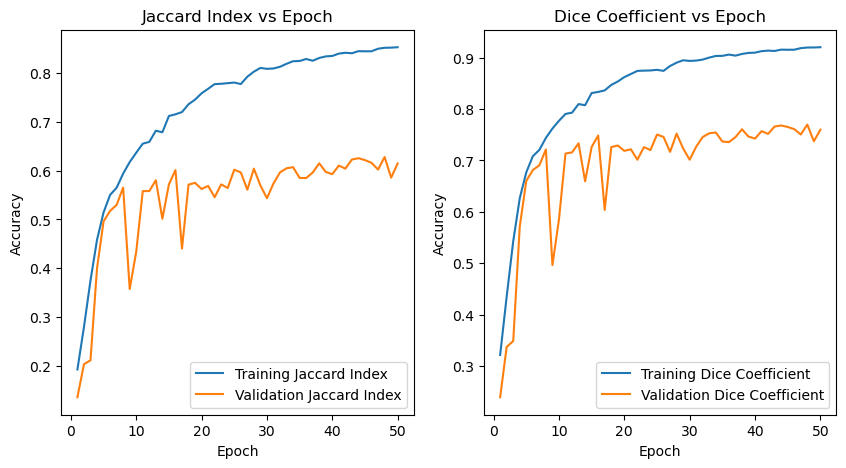

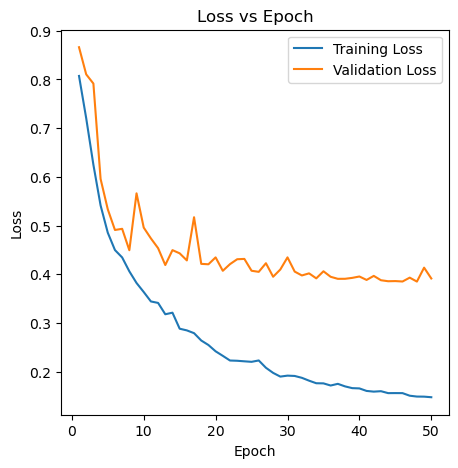

In [62]:
#Plot accuracy vs epoch
train_jaccard = history_Unet.history['Jaccard_index']
val_jaccard = history_Unet.history['val_Jaccard_index']
epoch_=list(range(1,51))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_,train_jaccard, label="Training Jaccard Index")
plt.plot(epoch_,val_jaccard, label="Validation Jaccard Index")
plt.legend()
plt.title("Jaccard Index vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#Plot accuracy vs epoch
train_jaccard = history_Unet.history['dice_coef']
val_jaccard = history_Unet.history['val_dice_coef']

plt.subplot(1, 2, 2)
plt.plot(epoch_,train_jaccard, label="Training Dice Coefficient")
plt.plot(epoch_,val_jaccard, label="Validation Dice Coefficient")
plt.legend()
plt.title("Dice Coefficient vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history_Unet.history['loss']
val_loss = history_Unet.history['val_loss']

plt.figure(figsize=(5, 5))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We can see that the Jaccard and Dice index plots have the same shape and trend. This is because Dice and Jaccard both measure the overlap between predicted segmentation and ground truth. 

The training accuracy keep increasing drastically until the last epoch. However, the validation accuracy increases a lot until epoch 10. The validation accuracy fluctuates and increases slowly after epoch 10. This suggests that the model might have converged.

The validation loss also show the same idea. The loss decreases until epoch.

Let's show some examples to see how well my model can segment tumors.

1/1 [==============================] - 0s 238ms/step


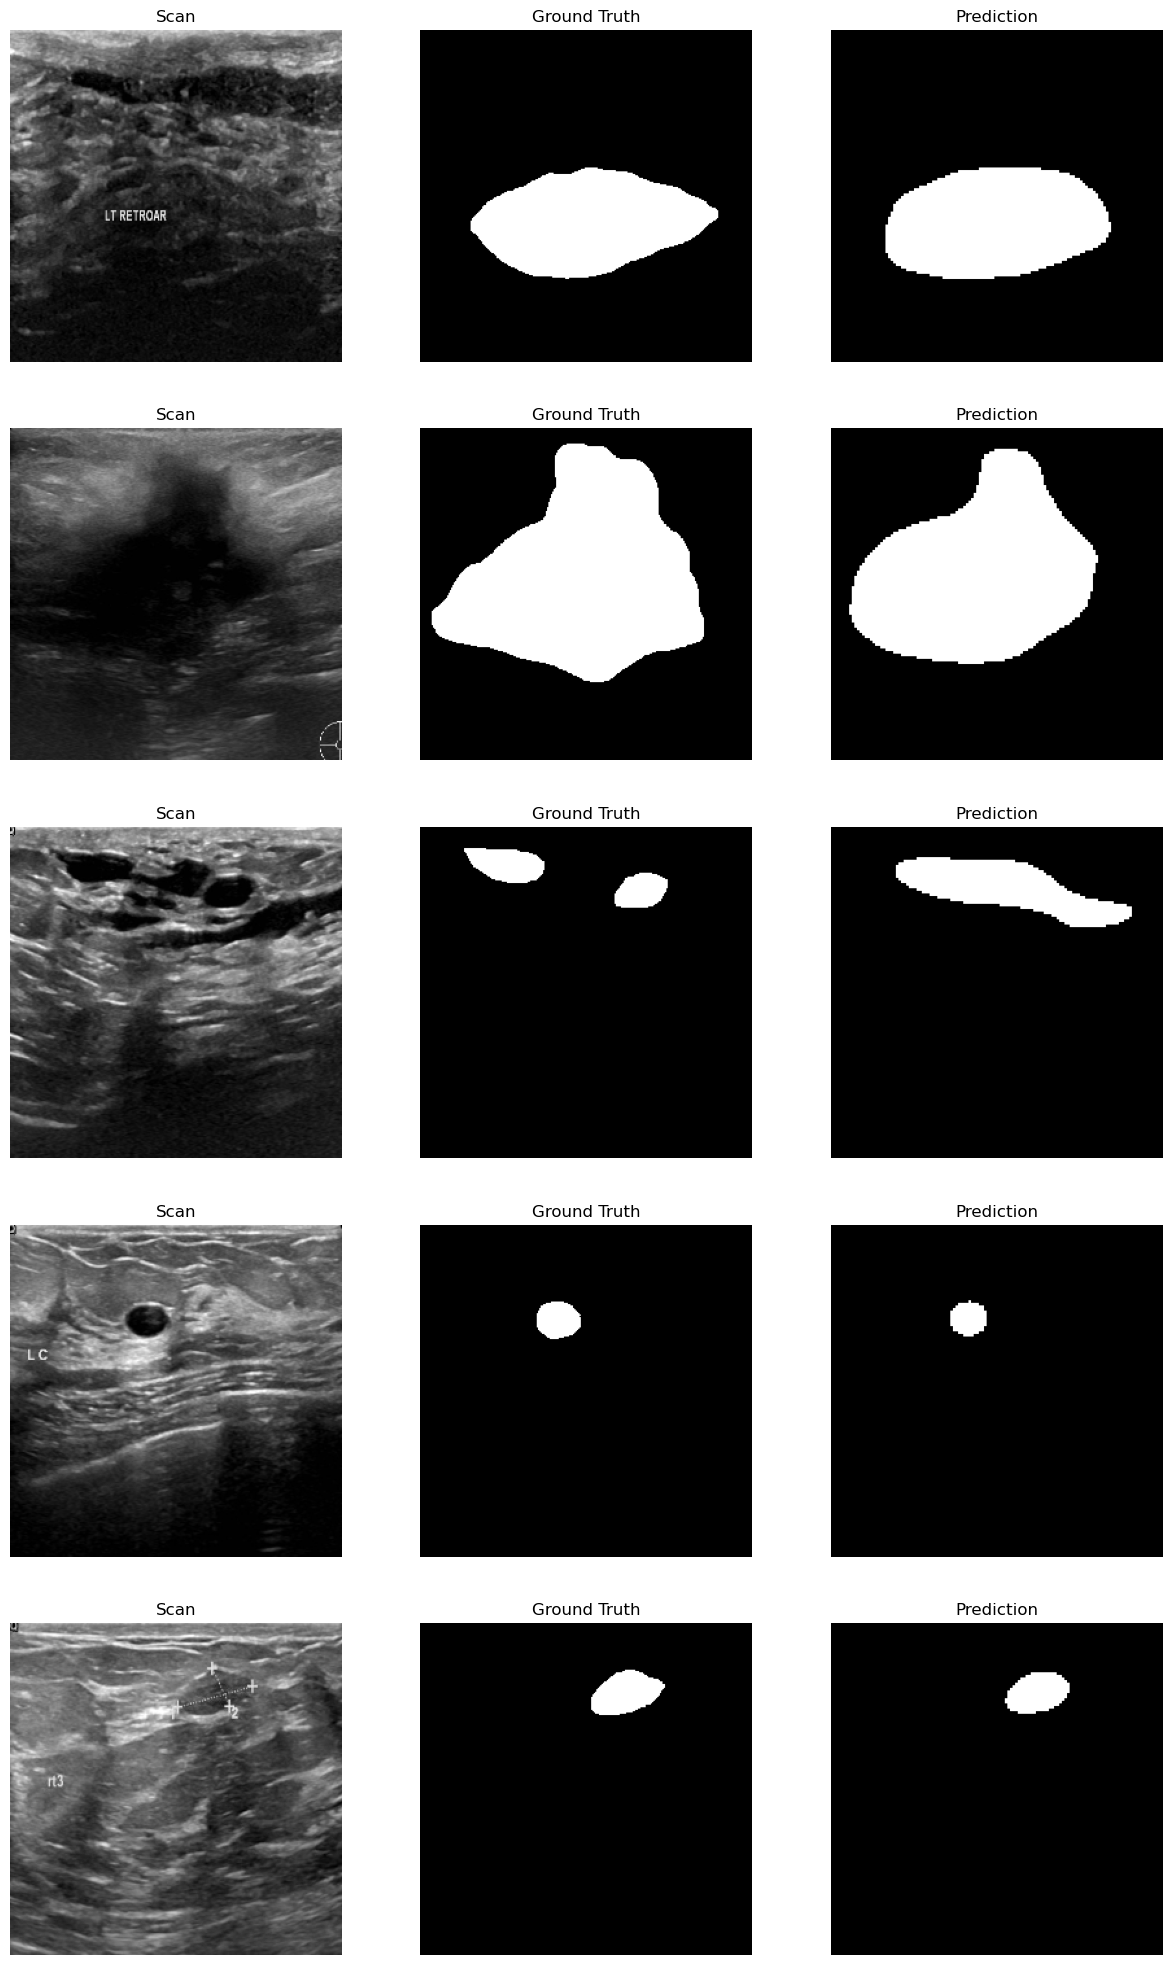

In [81]:
# Show example validation segmentation
#Make predictions
preds=Unet_Model.predict(image_test[0:5])
preds=np.squeeze(preds)
preds=np.around(preds, 0) #round possibility

# Plot
plt.figure(figsize=(15, 25))

for i in range(5):
    plt.subplot(5, 3, i*3+1)
    plt.imshow(image_test[i],cmap='gray')
    plt.axis("off")
    plt.title("Scan")
    plt.subplot(5, 3, i*3+2)
    plt.imshow(mask_test[i],cmap='gray')
    plt.axis("off")
    plt.title("Ground Truth")
    plt.subplot(5, 3, i*3+3)
    plt.imshow(preds[i],cmap='gray')
    plt.axis("off")
    plt.title("Prediction")


The Unet-CNN Model is able to segment tumors from scans well. The predicted segmentation is close to the grough truth. There are a lot of overlaps between the predictions and ground truth. This indicates that the model is able to extract important features from ultrasound scans and predict where the tumors are.

The location of the predicted and ground truth tumor overlap. The shape of the predictions and ground truths are close but the predicted segmentation seem smoother.

Let's look at the accuracy indices of my model on the test set.

In [85]:
# Make predictions on the test images
predictions = Unet_Model.predict(image_test)

# Compute the mean IoU metric on the test set
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(mask_test, predictions)
print("Mean Jaccard on test set: {:.3f}".format(mean_iou.result()))

# Compute the precision and recall on the test set
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(mask_test, predictions)
recall.update_state(mask_test, predictions)

print("Precision on test set: {:.3f}".format(precision.result()))
print("Reall on test set: {:.3f}".format(recall.result()))

# Compute the F1 score on the test set
f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())
print("F1 score on test set: {:.3f}".format(f1_score))


5/5 [==============================] - 2s 274ms/step
Mean Jaccard on test set: 0.756
Precision on test set: 0.795
Reall on test set: 0.725
F1 score on test set: 0.758


The accuracies indices are pretty high. Everything looks good. I think my model can segment the tumors well.

## Classification Models

Now, let's build some models to classify if the tumors are benign or malignant.

### Classification from scans
The first model only has input of the ultrasound scans. 

#### Model architecture

I decide to use a CNN model for this task because of its effeciency in proccessing and predict images.

My model will have an input size of 256x256x1. This is the input images size of 256x256 and 1 color channel.

There are 4 Convolutional layers followed by Max pooling layers. The Convolutional layers will extract important features from images and the max pooling will help reduce feature maps dimension for the next steps. I also added the Batch normalization for the model to be more efficient. Adding batch normalization can help reduce internal covariate shift, improve model stability, as well as speeding up the training.

Then the feature map is flattened and travels through a dense layer of 128 filters.

I also add Drop out layers with masking rate of 0.25. This would randomly change weights of 25% of the last layer to 0. The drop out layers will help reduce overfitting risk.

The output layer is a dense layer with activation function sigmoid giving the probability of image being cancerous.

In [99]:
# Classification Model from images
Class_Model_1 = keras.Sequential([
    Input(shape=(256, 256, 1)), # The input image dimension 256x256 by 1 color channel
    Conv2D(16, (3, 3), activation='relu'), # Convolutional layer with 16 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'), # Convolutional layer with 32 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'), # Convolutional layer with 64 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'), # Convolutional layer with 128 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Flatten(), # Flatten feature map to 1 dimension
    Dense(128, activation='relu'), # Dense layer with 128 neurons
    Dropout(0.25), # Drop out layer
    Dense(1, activation='sigmoid') # Output layer with sigmoid activation fuction
])

Class_Model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 254, 254, 16)      160       
                                                                 
 batch_normalization_94 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_109 (Dropout)       (None, 127, 127, 16)      0         
                                                                 
 conv2d_141 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_95 (Ba  (None, 125, 125, 32)     

#### Compile and Train
The model uses binary cross entropy loss function and Adam optimizer with initial learning rate of 0.001.

I also add early stopping which will monitor the validation loss and stop the training after 30 epochs if the validation loss doesn't decrease.

The model will also reduce it's learning rate by a factor of 0.1 after 10 epochs if the validation loss doesn't decrease. This would help the model converge.

I deicide to train the model for 50 epochs with a batch size of 32.

Let's train the model!

In [127]:
# Compile the model with the Binary cross entropy loss
Class_Model_1.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

# Define epochs and batch size
num_epochs = 50
batch_size = 32

# Train the UNet model on the training data
history_Class_1 = Class_Model_1.fit(image_train_aug, label_train_aug,batch_size=batch_size, epochs=num_epochs,callbacks=[early_stop, reduce_lr],validation_data=(image_test, label_test))


Epoch 1/50


2024-09-21 00:49:48.518776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - ETA: 0s - loss: 6.6424 - accuracy: 0.8080

2024-09-21 00:49:56.402811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 9s 119ms/step - loss: 6.6424 - accuracy: 0.8080 - val_loss: 8.3209 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 7s 106ms/step - loss: 7.1708 - accuracy: 0.7955 - val_loss: 11.1310 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 7s 110ms/step - loss: 5.8894 - accuracy: 0.8211 - val_loss: 10.0109 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 7s 106ms/step - loss: 5.4694 - accuracy: 0.8298 - val_loss: 24.4523 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 7s 106ms/step - loss: 5.2909 - accuracy: 0.8259 - val_loss: 8.1651 - val_accuracy: 0.7231 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 7s 105ms/step - loss: 5.7386 - accuracy: 0.8153 - val_loss: 29.5162 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 7s 107ms/step - loss: 4.7

The model stops training at epoch 39 because the validation loss doesn't decrease after 20 epochs.

#### Results


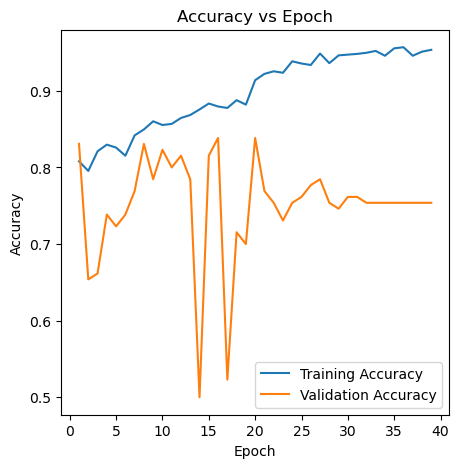

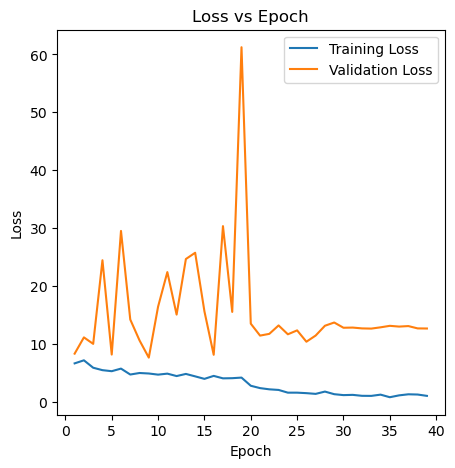

In [137]:
#Plot accuracy vs epoch
train_acc = history_Class_1.history['accuracy']
val_acc = history_Class_1.history['val_accuracy']
epoch_=list(range(1,40))

plt.figure(figsize=(5, 5))
plt.plot(epoch_,train_acc, label="Training Accuracy")
plt.plot(epoch_,val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history_Class_1.history['loss']
val_loss = history_Class_1.history['val_loss']

plt.figure(figsize=(5, 5))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We can see that the model converges fast. This is thanks to the large number of training data.

Let's look at other accuracy indices.

3/5 [=================>............] - ETA: 0s

2024-09-21 00:54:37.985203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 39ms/step


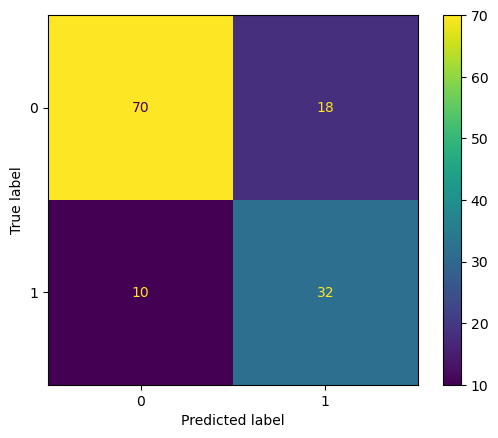

In [129]:
#Predict the test set
y_pred=Class_Model_1.predict(image_test)
y_pred=(y_pred > 0.5).astype(int).flatten()

#Confusion matrix
cm=confusion_matrix(label_test,y_pred)
ConfusionMatrixDisplay(cm).plot()

In [130]:
# Accuracy metrics
acc_1=accuracy_score(label_test,y_pred)
recall_1=recall_score(label_test,y_pred)
precision_1=precision_score(label_test,y_pred)
f1_1=f1_score(label_test,y_pred)

print('Accuracy = '+"{:.3f}".format(acc_1))
print('Recall = '+"{:.3f}".format(recall_1))
print('Precision = '+"{:.3f}".format(precision_1))
print('f1 = '+"{:.3f}".format(f1_1))

Accuracy = 0.785
Recall = 0.762
Precision = 0.640
f1 = 0.696


This model does a good job at predicting if the tumors are malginant or not. The model accuracy with the test set is 0.785. The f1 score is also pretty good.

For this problem, recall is an important index to look at. This is because I would like to achieve a low rate of false negative. This means patients. This is because the goal of this project is to identify patients with high risk of cancer. It is crucial that the model can identify high risk patients correctly with a low false negative rate. The recall rate is good in this model.

Let's see if we can imporve the model performance.

### Classification from Scans and Masks

This model will take in both the ultrasound scans and the tumor segmentation masks.

#### Model architecture

This model's input is 256x256x2. The input layer takes in 256x256 by 2 channels: images and masks.

The architecture is similar to the previous model with 4 Convolutional layers and an output layer with sigmoid activation function.

In [131]:
# Classification Model from images and masks
Class_Model_2 = keras.Sequential([
    Input(shape=(256, 256, 2)), # The input image dimension 256x256 by 2 channels: images and masks
    Conv2D(16, (3, 3), activation='relu'), # Convolutional layer with 16 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'), # Convolutional layer with 32 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'), # Convolutional layer with 64 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'), # Convolutional layer with 128 filters of size 3x3
    BatchNormalization(), # Batch normalization
    MaxPooling2D(2, 2), # Max pool 2x2
    Dropout(0.2),
    Flatten(), # Flatten feature map to 1 dimension
    Dense(128, activation='relu'), # Dense layer with 128 neurons
    Dropout(0.25), # Drop out layer
    Dense(1, activation='sigmoid') # Output layer with sigmoid activation fuction
])

Class_Model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 254, 254, 16)      304       
                                                                 
 batch_normalization_98 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_114 (Dropout)       (None, 127, 127, 16)      0         
                                                                 
 conv2d_145 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_99 (Ba  (None, 125, 125, 32)     

#### Compile and Train

First, I have to merge the images and their tumor masks into dimension 256x256x2.

This model also has binary cross entropy loss and Adam optimizer.

Early stopping and learning rate decay are also added.

Let's train the model.

In [136]:
#Merge Images and Masks
Combined_train=np.array([cv2.merge((image_train_aug[i], mask_train_aug[i])) for i in range(mask_train_aug.shape[0])])
Combined_test=np.array([cv2.merge((image_test[i], mask_test[i])) for i in range(mask_test.shape[0])])

# Compile the model with the Binary cross entropy loss
Class_Model_2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

# Define epochs and batch size
num_epochs = 50
batch_size = 32

# Train the UNet model on the training data
history_Class_2 = Class_Model_2.fit(Combined_train, label_train_aug,batch_size=batch_size, epochs=num_epochs,callbacks=[early_stop, reduce_lr],validation_data=(Combined_test, label_test))


Epoch 1/50


2024-09-21 00:59:22.828999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - ETA: 0s - loss: 13.4400 - accuracy: 0.6426

2024-09-21 00:59:31.446213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 9s 124ms/step - loss: 13.4400 - accuracy: 0.6426 - val_loss: 11.9153 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 8s 115ms/step - loss: 7.4083 - accuracy: 0.6688 - val_loss: 4.9393 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 8s 120ms/step - loss: 6.8298 - accuracy: 0.7215 - val_loss: 15.5990 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 8s 121ms/step - loss: 5.5231 - accuracy: 0.7640 - val_loss: 44.7171 - val_accuracy: 0.3231 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 8s 116ms/step - loss: 5.7287 - accuracy: 0.7776 - val_loss: 17.7967 - val_accuracy: 0.3769 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 8s 118ms/step - loss: 6.8194 - accuracy: 0.7882 - val_loss: 15.6566 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 8s 116ms/step - loss: 4

#### Results

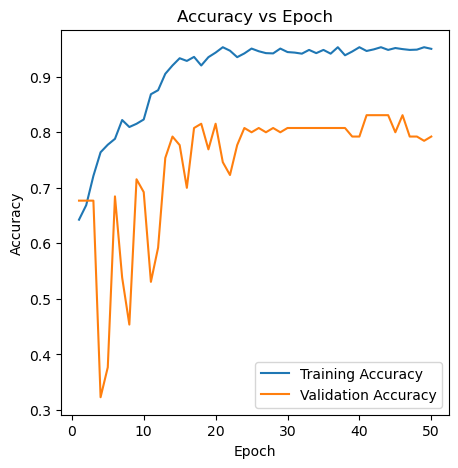

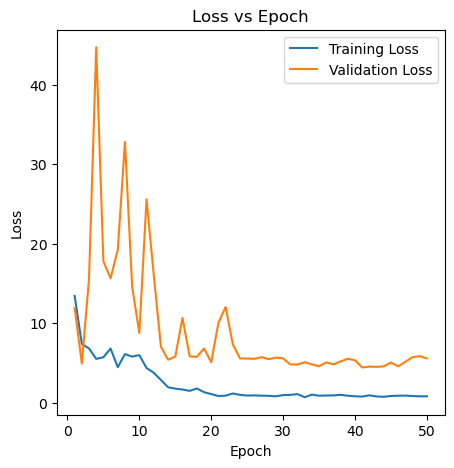

In [139]:
#Plot accuracy vs epoch
train_acc = history_Class_2.history['accuracy']
val_acc = history_Class_2.history['val_accuracy']
epoch_=list(range(1,51))

plt.figure(figsize=(5, 5))
plt.plot(epoch_,train_acc, label="Training Accuracy")
plt.plot(epoch_,val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history_Class_2.history['loss']
val_loss = history_Class_2.history['val_loss']

plt.figure(figsize=(5, 5))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

The model converges at around epoch 25. After that the training and validation accuracy and loss don't changes much.

Let's look at some accuracy indices

1/5 [=====>........................] - ETA: 0s

2024-09-21 01:07:24.382455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 34ms/step


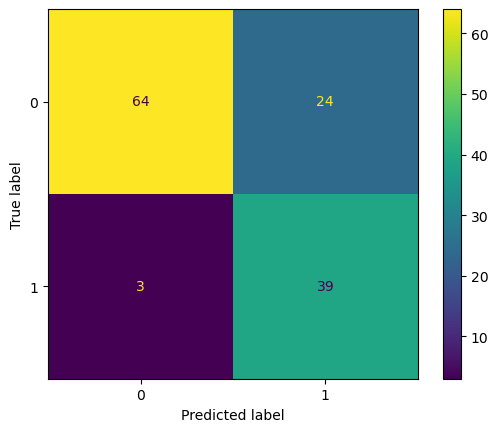

In [140]:
#Predict the test set
y_pred=Class_Model_2.predict(Combined_test)
y_pred=(y_pred > 0.5).astype(int).flatten()

#Confusion matrix
cm=confusion_matrix(label_test,y_pred)
ConfusionMatrixDisplay(cm).plot()

In [141]:
# Accuracy metrics
acc_2=accuracy_score(label_test,y_pred)
recall_2=recall_score(label_test,y_pred)
precision_2=precision_score(label_test,y_pred)
f1_2=f1_score(label_test,y_pred)

print('Accuracy = '+"{:.3f}".format(acc_2))
print('Recall = '+"{:.3f}".format(recall_2))
print('Precision = '+"{:.3f}".format(precision_2))
print('f1 = '+"{:.3f}".format(f1_2))

Accuracy = 0.792
Recall = 0.929
Precision = 0.619
f1 = 0.743


The model performance is better than the the previous model using only the ultrasound scans. The accuracy and f1 score increase from the last model.

The Recall is very good in this model. It only missclassifies 3 malignant tumors. This recall score os 0.93 is impressive. We can see that by adding the tumor segmentation mask to the model, the model can perform so much better.

However, in a real life situation, tumor segmentations are not easily made. It requires medical experts to look at the ultrasound scans and make decisions. It is impractical and expensive to have tumor segmentation with ultrasound scans. Therefore, we can use our segmentation model to predict the tumor segmentation. Then, let's try to classify the tumor using the images and predicted segmentation.

5/5 [==============================] - 0s 25ms/step


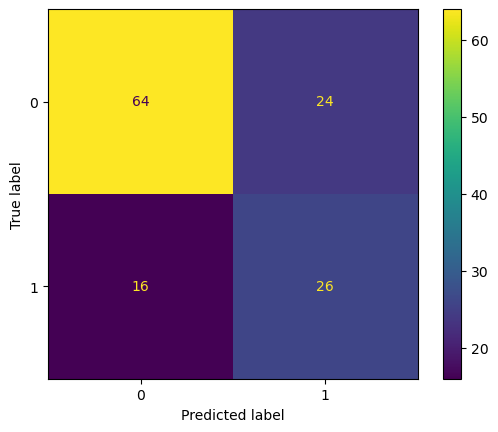

In [152]:
# Combine 2 models
# Make segmentation prediction
mask_pred=Unet_Model.predict(image_test)
mask_pred=np.squeeze(mask_pred)
mask_pred=np.around(mask_pred, 0)
mask_pred=mask_pred.astype('float64')

# Make classification prediction from mask prediction
Combined_pred=np.array([cv2.merge((image_test[i], mask_pred[i])) for i in range(mask_pred.shape[0])])
label_pred=Class_Model_2.predict(Combined_pred)
label_pred=(label_pred > 0.5).astype(int).flatten()

#Confusion matrix
cm=confusion_matrix(label_test,label_pred)
ConfusionMatrixDisplay(cm).plot()

In [153]:
# Accuracy metrics
acc_3=accuracy_score(label_test,label_pred)
recall_3=recall_score(label_test,label_pred)
precision_3=precision_score(label_test,label_pred)
f1_3=f1_score(label_test,label_pred)

print('Accuracy = '+"{:.3f}".format(acc_3))
print('Recall = '+"{:.3f}".format(recall_3))
print('Precision = '+"{:.3f}".format(precision_3))
print('f1 = '+"{:.3f}".format(f1_3))

Accuracy = 0.692
Recall = 0.619
Precision = 0.520
f1 = 0.565


When using the predicted segmentation and images to classify tumors, the model performs much worse. The accuracy indices are lower than just using the images only.

This is expected because my segmentation model isn't perfect. It can create some errors in tumor segmentation and those errors get echoed by the classification model.

Therefore, it is a good idea to use only the original images for both segmentation and classification.

## Final models

Let's compile my final segmentaion and classification models with a function.

This is my final product of this project.

In [177]:
# Combine final models
def Segment_Predict(image):
    img=np.expand_dims(image, axis=0)
    #Make mask prediction
    mask_pred=Unet_Model.predict(img)
    mask_pred=np.squeeze(mask_pred)
    mask_pred=np.around(mask_pred, 0)
    #Make class prediction
    class_pred=Class_Model_1.predict(img)
    y_pred=(class_pred > 0.5).astype(int).flatten()[0]
    #plot segmentation
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image,cmap='gray')
    plt.axis("off")
    plt.title("Scan")
    plt.subplot(1,2,2)
    plt.imshow(mask_pred,cmap='gray')
    plt.axis("off")
    plt.title("Tumor segmentation")
    plt.show()
    #print class prediction
    if y_pred==0:
        print('Tumor is benign.')
    else:
        print('Tumor is cancerous.')
    

1/1 [==============================] - 0s 62ms/step


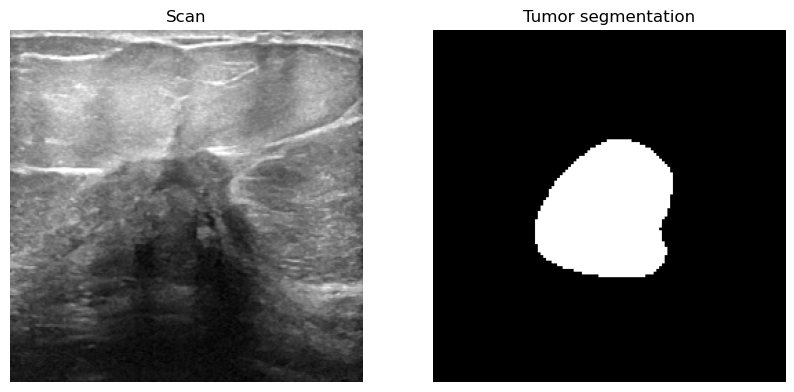

Tumor is cancerous.
1/1 [==============================] - 0s 9ms/step


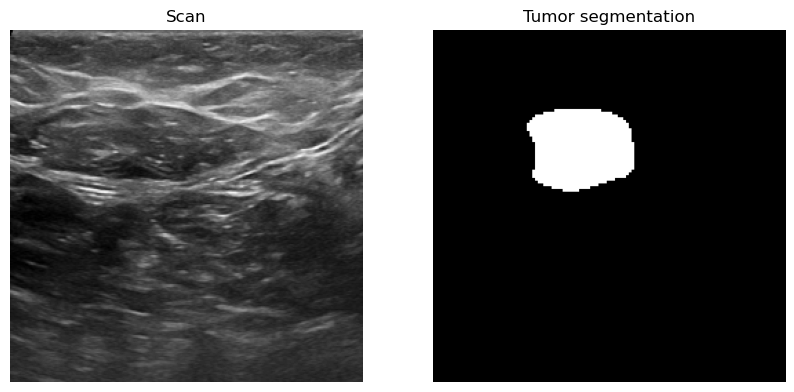

Tumor is benign.


In [188]:
# Predict some test images
Segment_Predict(image_test[16])
Segment_Predict(image_test[25])

## Discussion

My models perform pretty well with this data set.The segmentation model is able to segment the tumor from ultrasound scans with a Jaccrad index of 0.756 in the test data. This is considered a good performance. The segmentation model can locate where the tumors are but the outline and shape of the predicted tumors are somewhat different from the ground truths. For the classification model, the multiple convolutional layers have extracted important features from the images to identify malignant tumors. The classification model has a accuracy of 0.785 and recall of 0.762. By compiling both models, my final product is a model that can segment out the tumors and predict if they are malignant with a good accuracy.

I believe that my preprocessing the data plays a huge role in increasing the model performance. This includes normalizing pixels, resizing, and augmentation. 

There are still room for improvement. In the future, I think I can increase the complexity of the models by adding more convolutional layers and more filters. This would help the model to learn deeper features from the ultrasound scans.

Overall, my project has created deep learning model that can segment the breast mass from ultrasound scans and predict if they are malignant or benign with a good accuracy. This could act as an aid to physicians in diagnosing breast cancer.